In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dc-motor/reading_log_20250626_190021.csv
/kaggle/input/dc-motor/reading_log_20250626_185157.csv
/kaggle/input/dc-motor/reading_log_20250626_185723.csv


### Loading the CSV Files 

In [2]:
normal = pd.read_csv('/kaggle/input/dc-motor/reading_log_20250626_185157.csv')
load = pd.read_csv('/kaggle/input/dc-motor/reading_log_20250626_185723.csv')
random = pd.read_csv('/kaggle/input/dc-motor/reading_log_20250626_190021.csv')

### Parameters 


In [3]:
numSamples = 5000
shifting = 5 
columnNumber = 1
shiftRange = 200

### Dataset Generation 

In [4]:
import numpy as np
import pandas as pd

def generate(signal_df: pd.DataFrame, label: int, 
                                 segment_length: int = 2000, 
                                 num_segments: int = numSamples, 
                                 shifts_per_segment: int = shifting,
                                 shift_range: tuple = (-shiftRange, shiftRange)) -> pd.DataFrame:
    
    signal = signal_df.iloc[:, columnNumber].values
    max_start = len(signal) - segment_length

    samples = []

    for _ in range(num_segments):
        start_idx = np.random.randint(0, max_start)
        segment = signal[start_idx:start_idx + segment_length]

        unshifted = np.append(segment, label)
        samples.append(unshifted)

        for _ in range(shifts_per_segment):
            shift = np.random.uniform(*shift_range)
            shifted_segment = segment + shift
            shifted = np.append(shifted_segment, label)
            samples.append(shifted)

    columns = [f"v{i}" for i in range(segment_length)] + ["label"]
    return pd.DataFrame(samples, columns=columns)


In [5]:
normal = generate(normal, label=0)
load = generate(load, label=0)
random_1 = generate(random, label=1)
random_2 = generate(random, label=1)

### Train and Test Dataset Split 

In [6]:
from sklearn.model_selection import train_test_split

combined_df = pd.concat([normal, load, random_1, random_2], ignore_index=True)

train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,         
    stratify=combined_df['label'], 
    random_state=42       
)

print("Train label counts:\n", train_df['label'].value_counts())
print("Test label counts:\n", test_df['label'].value_counts())

Train label counts:
 label
0.0    48000
1.0    48000
Name: count, dtype: int64
Test label counts:
 label
1.0    12000
0.0    12000
Name: count, dtype: int64


### Plot few samples from Train and Test Dataset 

In [7]:
num = 5 

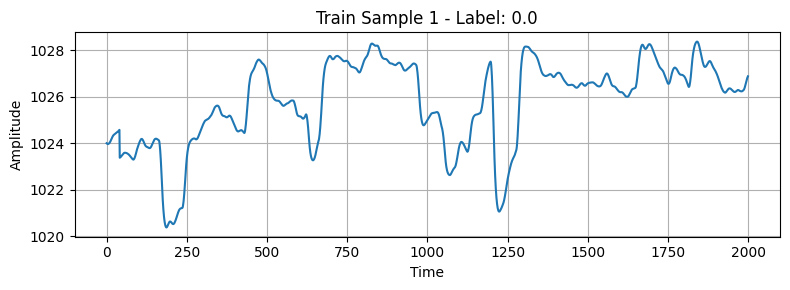

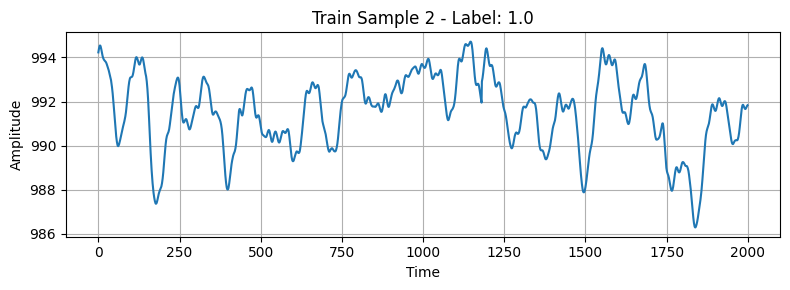

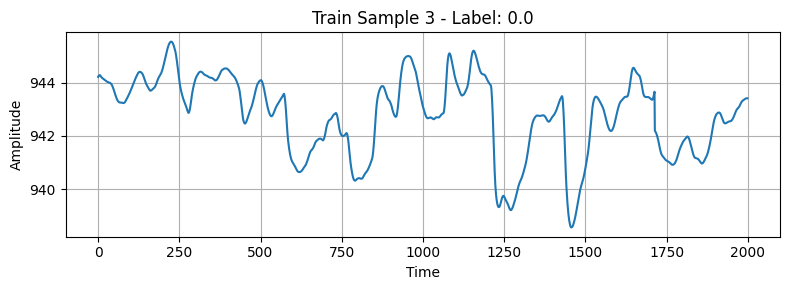

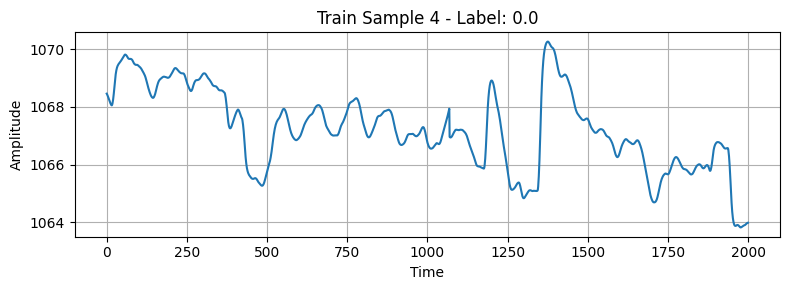

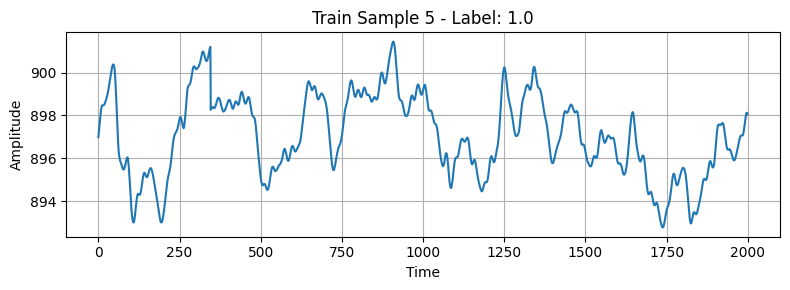

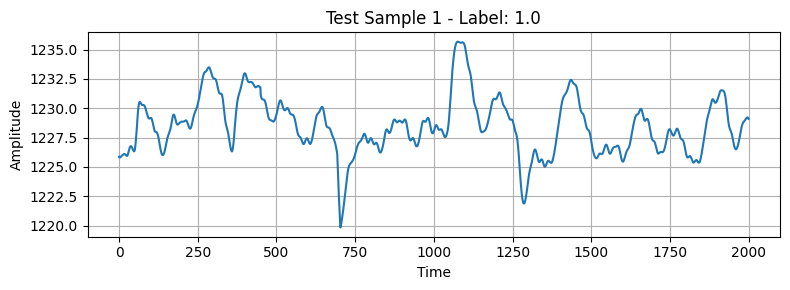

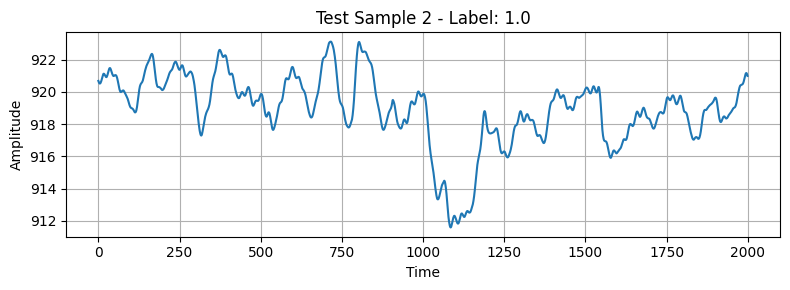

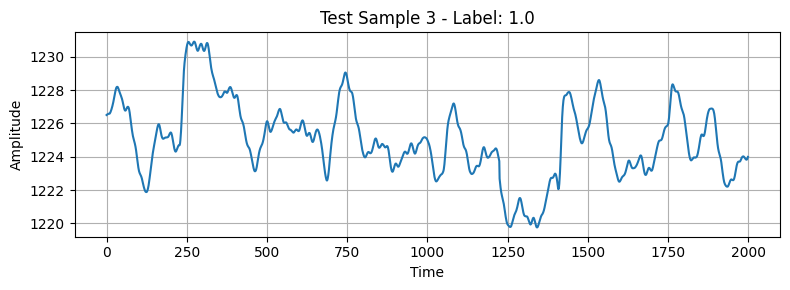

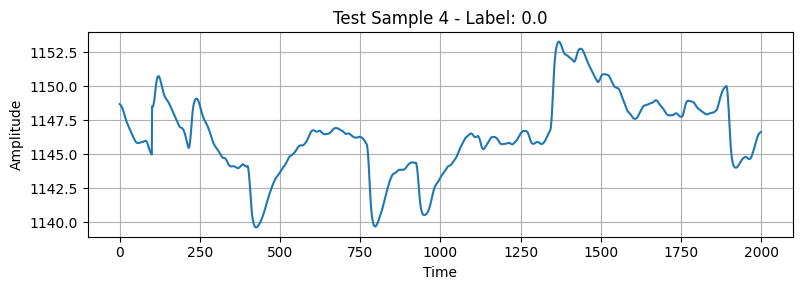

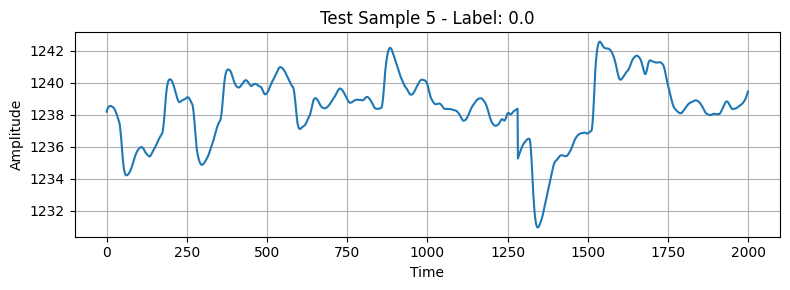

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def plot_individual_samples(df, dataset_name, column_start=0, column_end=-1):
    sample_df = df.sample(n=num, random_state=42).reset_index(drop=True)
    
    for idx in range(num):
        row = sample_df.iloc[idx]
        label = row['label']

        if column_end == -1:
            signal = row.iloc[column_start:-1].values.astype(float) 
        else:
            signal = row.iloc[column_start:column_end].values.astype(float)

        plt.figure(figsize=(8, 3))
        plt.plot(signal)
        plt.title(f"{dataset_name} Sample {idx+1} - Label: {label}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_individual_samples(train_df, dataset_name="Train")
plot_individual_samples(test_df, dataset_name="Test")


# ResNet

### Model Definition and Training 

In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import random

df = train_df
X = df.drop('label', axis=1).values
y = df['label'].values.astype(int)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=100, stratify=y, random_state=42)

scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(X_dev)
X_test_scaled = scaler.transform(X_test)

X_dev_scaled = X_dev_scaled.reshape(-1, 1, 40, 50)
X_test_scaled = X_test_scaled.reshape(-1, 1, 40, 50)

X_train, X_val, y_train, y_val = train_test_split(X_dev_scaled, y_dev, test_size=0.2, stratify=y_dev, random_state=42)

class SignalDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SignalDataset(X_train, y_train)
val_ds = SignalDataset(X_val, y_val)
test_ds = SignalDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_ds, batch_size=50, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=50)
test_loader = DataLoader(test_ds, batch_size=50)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, dropout=0.3):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        out = self.conv_block(x)
        out = self.dropout(out)
        return self.relu(x + out)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = BasicBlock(64)
        self.layer2 = BasicBlock(64)
        self.layer3 = BasicBlock(64)
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)
    return correct / total

def train_model(model, train_loader, val_loader, epochs=100, patience=10):
    best_acc = 0
    wait = 0
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

        val_acc = evaluate(model, val_loader)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Train Acc: {correct/total:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)

train_model(model, train_loader, val_loader)

test_acc = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Epoch 01 | Loss: 0.6655 | Train Acc: 0.5821 | Val Acc: 0.5846
Epoch 02 | Loss: 0.6540 | Train Acc: 0.5968 | Val Acc: 0.5878
Epoch 03 | Loss: 0.6471 | Train Acc: 0.6061 | Val Acc: 0.6067
Epoch 04 | Loss: 0.6411 | Train Acc: 0.6162 | Val Acc: 0.6189
Epoch 05 | Loss: 0.6372 | Train Acc: 0.6217 | Val Acc: 0.6151
Epoch 06 | Loss: 0.3978 | Train Acc: 0.8050 | Val Acc: 0.9037
Epoch 07 | Loss: 0.2288 | Train Acc: 0.9063 | Val Acc: 0.9254
Epoch 08 | Loss: 0.1323 | Train Acc: 0.9484 | Val Acc: 0.9557
Epoch 09 | Loss: 0.0725 | Train Acc: 0.9741 | Val Acc: 0.9660
Epoch 10 | Loss: 0.0424 | Train Acc: 0.9855 | Val Acc: 0.9880
Epoch 11 | Loss: 0.0289 | Train Acc: 0.9905 | Val Acc: 0.9942
Epoch 12 | Loss: 0.0259 | Train Acc: 0.9913 | Val Acc: 0.9950
Epoch 13 | Loss: 0.0199 | Train Acc: 0.9932 | Val Acc: 0.9969
Epoch 14 | Loss: 0.0111 | Train Acc: 0.9965 | Val Acc: 0.9998
Epoch 15 | Loss: 0.0298 | Train Acc: 0.9896 | Val Acc: 0.9993
Epoch 16 | Loss: 0.0089 | Train Acc: 0.9971 | Val Acc: 0.9988
Epoch 17

### Testing on Test Dataset 

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

new_test_df = test_df
X_new_test = new_test_df.drop('label', axis=1).values
y_true = new_test_df['label']

X_new_test_scaled = scaler.transform(X_new_test)
X_new_test_scaled = X_new_test_scaled.reshape(-1, 1, 40, 50)

model.eval()
new_test_ds = TensorDataset(torch.tensor(X_new_test_scaled).float())
new_test_loader = DataLoader(new_test_ds, batch_size=50)

new_preds = []
with torch.no_grad():
    for xb in new_test_loader:
        xb = xb[0].to(device)
        preds = model(xb).argmax(dim=1)
        new_preds.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, new_preds)
prec = precision_score(y_true, new_preds)
rec = recall_score(y_true, new_preds)

print(f"\nEvaluation on test dataframe:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")



Evaluation on test dataframe:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000


### Save the Model 

In [11]:
import joblib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.eval()

dummy_input = torch.randn(1, 1, 40, 50).to(device)

traced_model = torch.jit.trace(model, dummy_input)
traced_model.save('model.pt')
joblib.dump(scaler, 'scaker.pkl')

['scaker.pkl']

# CNN

In [ ]:
class CNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.classifier(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN2D().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

train_model(model, train_loader, val_loader)
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.eval()

dummy_input = torch.randn(1, 1, 40, 50).to(device)
traced_model = torch.jit.trace(model, dummy_input)

traced_model.save("CNN_2D.pt")

# U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def center_crop(enc_feat, target_feat):
    _, _, h, w = enc_feat.shape
    _, _, th, tw = target_feat.shape
    dh, dw = (h - th) // 2, (w - tw) // 2
    return enc_feat[:, :, dh:dh+th, dw:dw+tw]

class UNet2D(nn.Module):
    def __init__(self):
        super(UNet2D, self).__init__()
        
        self.enc1 = self.conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.bottleneck = self.conv_block(128, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 2)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        up2 = self.up2(bottleneck)
        enc2 = center_crop(enc2, up2)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.up1(dec2)
        enc1 = center_crop(enc1, up1)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return self.classifier(dec1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet2D().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

train_model(model, train_loader, val_loader)
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.eval()

dummy_input = torch.randn(1, 1, 40, 50).to(device)
traced_model = torch.jit.trace(model, dummy_input)

traced_model.save("UNet.pt")

# VGG

In [ ]:
class VGG2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG2D().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

train_model(model, train_loader, val_loader)
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.eval()

dummy_input = torch.randn(1, 1, 40, 50).to(device)
traced_model = torch.jit.trace(model, dummy_input)

traced_model.save("VGG_2D.pt")

# MLP

In [ ]:
import torch
import torch.nn as nn

class MLP2D(nn.Module):
    def __init__(self, input_shape=(1, 40, 50), hidden_dim=128, output_dim=2):
        super().__init__()
        self.flatten = nn.Flatten()
        input_dim = input_shape[0] * input_shape[1] * input_shape[2]  # 1*40*50 = 2000
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)  # 2 classes
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.classifier(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP2D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

train_model(model, train_loader, val_loader)

test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
dummy_input = torch.randn(1, 1, 40, 50).to(device)
traced = torch.jit.trace(model, dummy_input)
traced.save("MLP_2D.pt")